<a href="https://colab.research.google.com/github/sabeesh90/EVA6_master/blob/main/resnet_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Navigation inside root directory

In [1]:
  !pip install albumentations==0.4.6

In [2]:
import torchvision

from IPython.display import clear_output
import shutil
import  os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
os.chdir('/content/')
shutil.rmtree('EVA6_master')
import warnings
warnings.filterwarnings('ignore')
import pickle
# os.chdir('/content/')

##### Cloning the repository

In [3]:
!git clone https://github.com/sabeesh90/EVA6_master.git


Cloning into 'EVA6_master'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 323 (delta 148), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (323/323), 1010.49 KiB | 5.98 MiB/s, done.
Resolving deltas: 100% (148/148), done.


##### navgiating to models folder and loading requisite libraries

In [4]:

%cd EVA6_master/"main and utils"
import main2
from main2 import *
import custom_resnet
from custom_resnet import *
resnet = ResNet18()

/content/EVA6_master/main and utils


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, count, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        self.count1= count

        # if stride != 1 or in_planes != self.expansion*planes:
        if self.count1 == 'a':
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.ReLU(),
                nn.Conv2d(self.expansion*planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.count1 == 'a':
            y  = self.shortcut(x)
            print(out.shape, y.shape)   
            out = out+y
            out = F.relu(out)
            return out
        out = F.max_pool2d(out,kernel_size=(2,2))                 
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 128, num_blocks[0], count = 'a',stride=1 )
        self.layer2 = self._make_layer(block, 256, num_blocks[1], count = 'b', stride=2)
        self.layer3 = self._make_layer(block, 512, num_blocks[2], count = 'a', stride=1)
        
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, count,stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, count, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        print(out.shape) # 128,512,8,8
        out = F.avg_pool2d(out, 4)
        print(out.shape) # 128,512,2,2
        out = out.view(out.size(0), -1)
        print(out.shape)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [1, 1, 1])


In [43]:
resnet = ResNet18()

In [44]:
cuda = torch.cuda.is_available()
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)
device = torch.device("cuda" if cuda else "cpu")
model_generated = resnet.to(device)
print(summary(model_generated, input_size=(3,32,32)))

torch.Size([2, 128, 32, 32]) torch.Size([2, 128, 32, 32])
torch.Size([2, 512, 8, 8]) torch.Size([2, 512, 8, 8])
torch.Size([2, 512, 8, 8])
torch.Size([2, 512, 2, 2])
torch.Size([2, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]           8,192
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          16,384
       BatchNorm2d-9          [-1, 128, 32, 32]             256
       BasicBlock-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 16,

In [21]:
nn.Sequential(*list(model_generated.children()))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, mome

##### Generating train and test dataset

In [9]:
trainloader, testloader = generate_dataset()


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


##### Importing training algorithms

In [45]:
import train_test
from train_test import *
optimizer, scheduler =  create_optim(model_generated,trainloader)

##### Training the model

In [46]:
epochs = 40
device = 'cuda'
for epoch in range(epochs):
    print("EPOCH:", epoch)
    train(model_generated,trainloader, optimizer,device,scheduler)
    test(model_generated, testloader,device)









  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0
391
torch.Size([128, 128, 32, 32]) torch.Size([128, 128, 32, 32])
torch.Size([128, 512, 8, 8]) torch.Size([128, 512, 8, 8])
torch.Size([128, 512, 8, 8])
torch.Size([128, 512, 2, 2])
torch.Size([128, 2048])


RuntimeError: ignored

##### Plotting the training vs Validation accuracy / losses

In [ ]:
new_train_acc = []
i = 1
for value in range(1,41):    
    a = i+391
    new_train_acc.append(sum(train_acc[i:a])/len(train_acc[i:a]))
    i = a

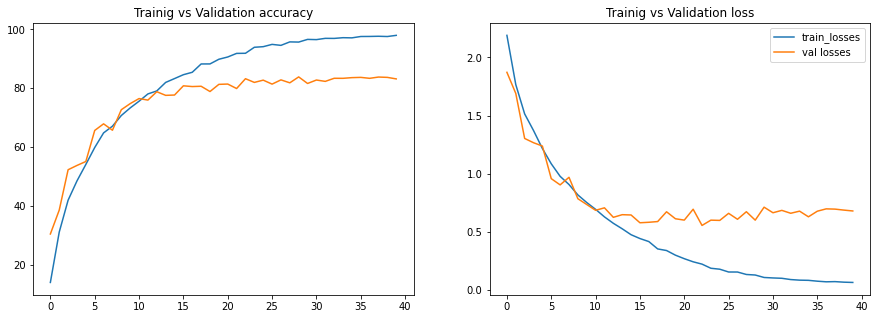

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(new_train_acc, label = 'train_acc')
plt.plot(test_acc, label = 'val_acc')
plt.title('Trainig vs Validation accuracy')

plt.subplot(1,2,2)
plt.plot(train_losses, label = 'train_losses')
plt.plot(test_losses, label = 'val losses')
plt.title('Trainig vs Validation loss')

plt.legend(loc = 'best')
plt.show()


##### SAving the model

In [ ]:
filename = 'finalized_model_40.sav'
pickle.dump(my_model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

##### Generating the cam for the predicted class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

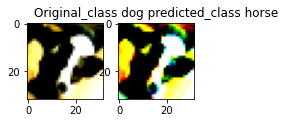

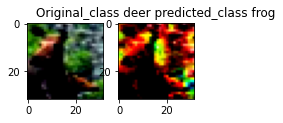

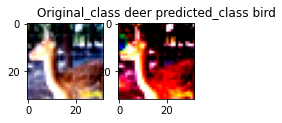

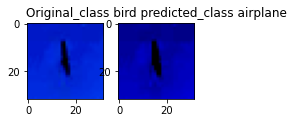

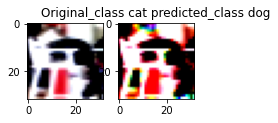

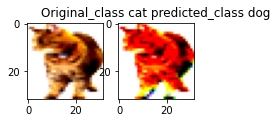

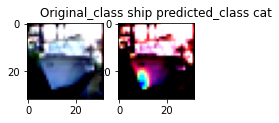

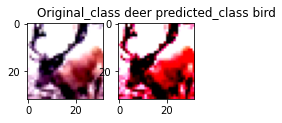

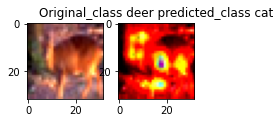

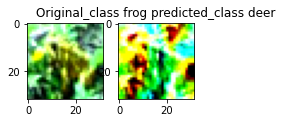

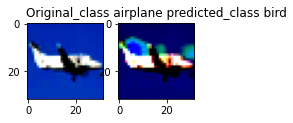

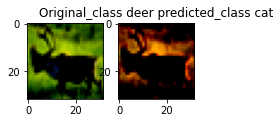

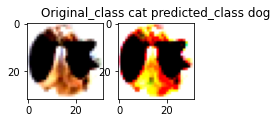

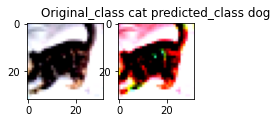

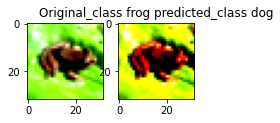

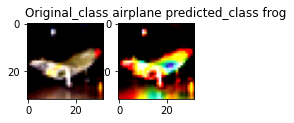

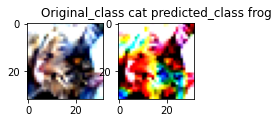

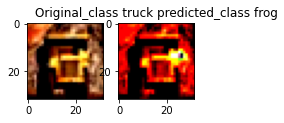

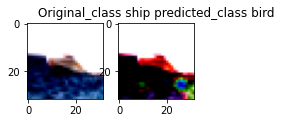

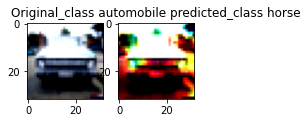

In [ ]:
activated_mod = ResNet_Mod(loaded_model)
get_true_pred(testloader,activated_mod,20,class_dictionary)